In [268]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import sys
sys.path.append("..")
from src.datasets_labeled import labeled_datasets
from src.ETL.constants import LAT, LON, SUBSET, CROP_PROB

# Load Tigray maps

In [272]:
# Boundary path
b_path = "/Users/izvonkov/Downloads/eth_admbnda_adm1_csa_bofed_20201008.shp"

root = "/Users/izvonkov/Desktop"
Seths = {
    "2020_1": f"{root}/drive-download-20211216T194323Z-002/tigray_JanSep_2020_0pt35t_nov17a_binaryyNt-001.tif",
    "2020_2": f"{root}/drive-download-20211216T194323Z-002/tigray_JanSep_2020_0pt35t_nov17a_binaryySEt.tif",
    "2021_1": f"{root}/drive-download-20211216T194323Z-002/tigray_JanSep_2021_0pt35t_nov17a_binaryyNt-002.tif",
    "2021_2": f"{root}/drive-download-20211216T194323Z-002/tigray_JanSep_2021_0pt35t_nov17a_binaryySEt.tif"
}

ours = {
    "2020_v2": f"{root}/Ethiopia_Tigray_2020_v2.tiff",
    "2021_v2": f"{root}/Ethiopia_Tigray_2021_v2.tiff"
}

In [273]:
Seths_tifs = {k: rio.open(p) for k,p in Seths.items()}
our_tifs = {k: rio.open(p) for k,p in ours.items()}

# Load labels

In [274]:
df_2020 = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2020"][0].load_labels(allow_processing=False)
df_2021 = [d for d in labeled_datasets if d.dataset == "Ethiopia_Tigray_2021"][0].load_labels(allow_processing=False)

# Filter out points not inside map

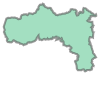

In [275]:
# Get shapefile
boundaries = gpd.read_file(b_path)
tigray_boundary = boundaries.iloc[0].geometry
tigray_boundary

In [374]:
def in_map(gdf):
    return gdf.geometry.apply(lambda x: tigray_boundary.contains(x))

In [377]:
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=gpd.points_from_xy(x=df_2020.lon, y=df_2020.lat))
gdf_2020 = gdf_2020[in_map(gdf_2020)]

In [379]:
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=gpd.points_from_xy(x=df_2021.lon, y=df_2021.lat))
gdf_2021 = gdf_2021[in_map(gdf_2021)]

In [380]:
gdf_2020["is_crop"] = (gdf_2020[CROP_PROB] > 0.5).astype(float)
gdf_2021["is_crop"] = (gdf_2021[CROP_PROB] > 0.5).astype(float)

In [381]:
def plot_set(gdf, title):
    fig, ax = plt.subplots(1, figsize=(15,15))
    boundaries.plot(ax=ax, color="lightgray")
    crop = gdf[gdf["is_crop"] == 0.0]
    non_crop = gdf[gdf["is_crop"] == 1.0]
    total = len(crop) + len(non_crop)
    crop.plot(ax=ax, color="yellow", label=f"Non-crop: {len(non_crop) / total:.3}")
    non_crop.plot(ax=ax, color="green", label=f"Crop: {len(crop) / total:.3}")
    ax.legend(loc=3, prop={'size': 15}, markerscale=2)
    ax.set_title(title, fontsize=20)
    ax.axis('off')

In [382]:
def print_metrics(actual, preds, title):
    print("---------------------------------------------------")
    print(title)
    print("---------------------------------------------------")
    print(f"F1-Score:\t{f1_score(actual, preds):.3}")
    print(f"Precision:\t{precision_score(actual, preds):.3}")
    print(f"Recall: \t{recall_score(actual, preds):.3}")
    print(f"Accuracy:\t{accuracy_score(actual, preds):.3}")

# Predictions on validation set

In [383]:
gdf_2020_val = gdf_2020[(gdf_2020[SUBSET] == "validation") & gdf_2020["in_map"]].copy()
gdf_2021_val = gdf_2021[(gdf_2021[SUBSET] == "validation") & gdf_2021["in_map"]].copy()

---------------------------------------------------
2020 Our predictions on validation set
---------------------------------------------------
F1-Score:	0.679
Precision:	0.625
Recall: 	0.743
Accuracy:	0.785
---------------------------------------------------
2020 Seth's predictions on our validation set
---------------------------------------------------
F1-Score:	0.649
Precision:	0.636
Recall: 	0.662
Accuracy:	0.781


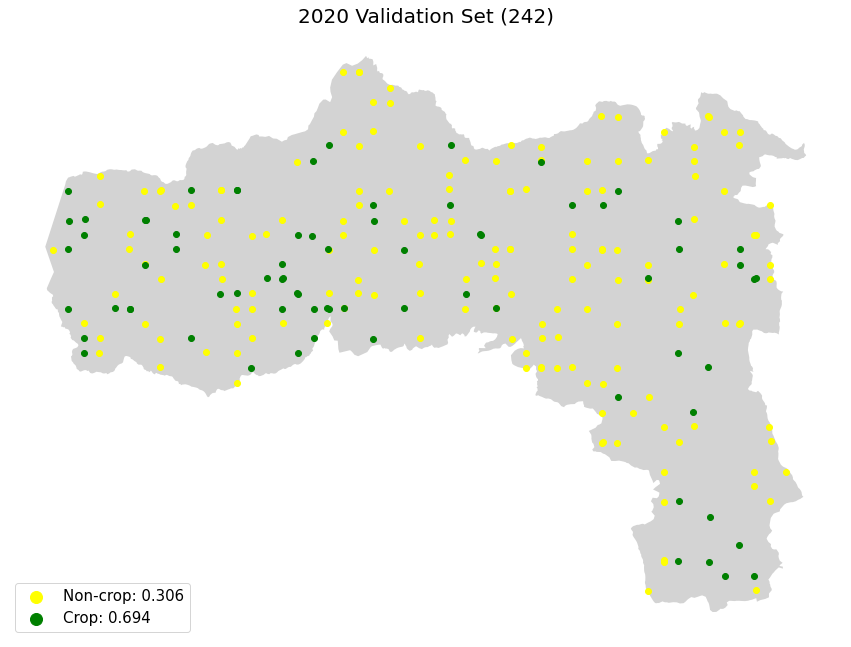

In [368]:
# Verify predictions on validation set:
# (ie. most cloud free month is different when exporting 10x10 tile vs inference size tile)
preds = gdf_2020_val.geometry.apply(lambda p: next(our_tifs["2020_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2020_val["is_crop"], preds, "2020 Our predictions on validation set")

# All hold out 2021 data is in validation set so have to test Seth's data here too
Seth_preds = gdf_2020_val.geometry.apply(lambda p: next(Seths_tifs["2020_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2020_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2020_val["is_crop"], Seth_preds, "2020 Seth's predictions on our validation set")
plot_set(gdf_2020_val, title=f"2020 Validation Set ({len(gdf_2020_val)})")

---------------------------------------------------
2021 our predictions on validation set
---------------------------------------------------
F1-Score:	0.624
Precision:	0.512
Recall: 	0.796
Accuracy:	0.632
---------------------------------------------------
2021 Seth's predictions on validation set
---------------------------------------------------
F1-Score:	0.468
Precision:	0.673
Recall: 	0.359
Accuracy:	0.688


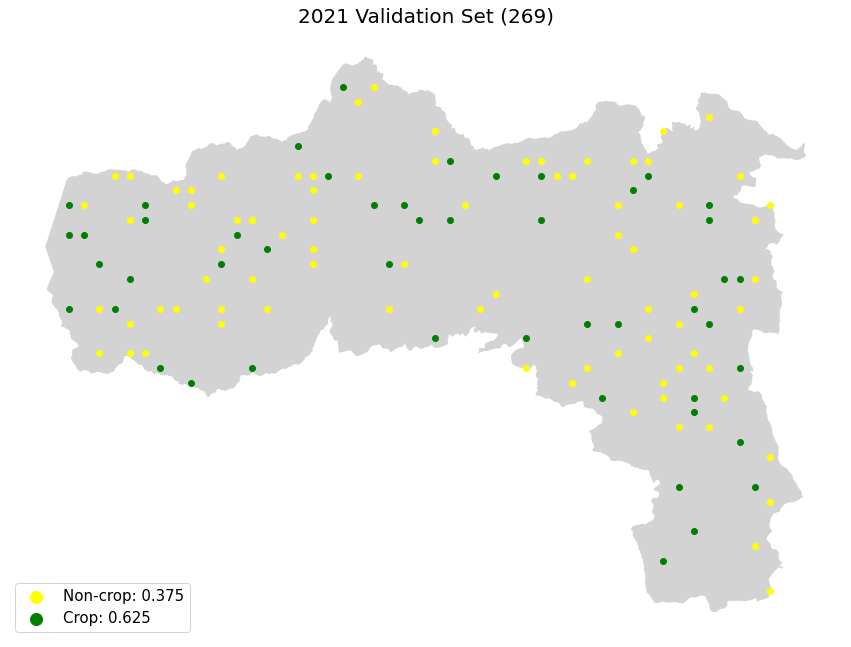

In [369]:
preds = gdf_2021_val.geometry.apply(lambda p: next(our_tifs["2021_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2021_val["is_crop"], preds, "2021 our predictions on validation set")

# All hold out 2021 data is in validation set so have to test Seth's data here too
Seth_preds = gdf_2021_val.geometry.apply(lambda p: next(Seths_tifs["2021_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2021_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2021_val["is_crop"], Seth_preds, "2021 Seth's predictions on validation set")

plot_set(gdf_2021_val, title=f"2021 Validation Set ({len(gdf_2021_val)})")

# Predictions on small test set (only available for 2020)

---------------------------------------------------
2020 Our predictions on our test set
---------------------------------------------------
F1-Score:	0.577
Precision:	0.542
Recall: 	0.616
Accuracy:	0.719
---------------------------------------------------
2020 Seth's predictions on our test set
---------------------------------------------------
F1-Score:	0.618
Precision:	0.667
Recall: 	0.575
Accuracy:	0.779


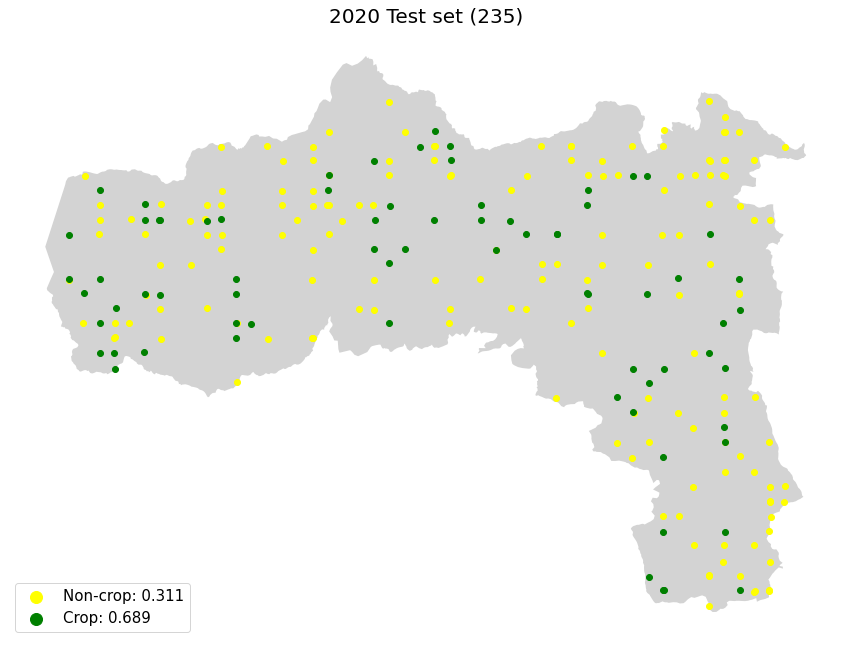

In [370]:
gdf_2020_test = gdf_2020[(gdf_2020[SUBSET] == "testing") & gdf_2020["in_map"]].copy()

our_preds = gdf_2020_test.geometry.apply(lambda p: next(our_tifs["2020_v2"].sample([(p.x, p.y)]))[0] > 0.5)
print_metrics(gdf_2020_test["is_crop"], our_preds, title="2020 Our predictions on our test set")

Seth_preds = gdf_2020_test.geometry.apply(lambda p: next(Seths_tifs["2020_1"].sample([(p.x, p.y)]))[0] or next(Seths_tifs["2020_2"].sample([(p.x, p.y)]))[0])
print_metrics(gdf_2020_test["is_crop"], Seth_preds, title="2020 Seth's predictions on our test set")

plot_set(gdf_2020_test, f"2020 Test set ({len(gdf_2020_test)})")

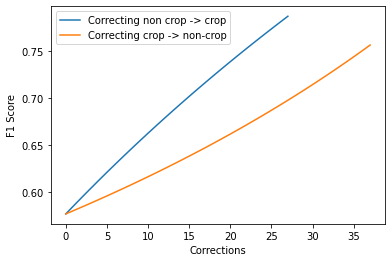

In [194]:
fig, ax = plt.subplots(1,1)
pd.DataFrame({"Corrections": corrections, "F1 Score": f1_scores}).plot.line(
    x="Corrections", 
    y="F1 Score", 
    ax=ax, 
    label="Correcting non crop -> crop");

pd.DataFrame({"Corrections": corrections2, "F1 Score": f1_scores2}).plot.line(
    x="Corrections", 
    y="F1 Score", 
    ax=ax, 
    label="Correcting crop -> non-crop");

ax.set_ylabel("F1 Score");